# Part II - (US Flights of 2008)
## by (Khawla Alqarni)



## Investigation Overview

Exploring US flights of 2008 and answering on:-

* what is the percentage causes of Delayed flights?
* is the Departure Delay normally distributed ?
* Which Airport have largest number of Flights? 
* Is Departure delay lead to Arrival delay?
* What is the number of Delay in each Airline by Months and total flights?
* what are the reaons of cancellation in each Airline?
* What is the Average Flights Diverted by months and weekdays?


## Dataset Overview

> The 2009 ASA Statistical Computing and Graphics Data Expo consisted of flight arrival and departure details for all commercial flights on major carriers within the USA, from October 1987 to April 2008. 

In [3]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [4]:
# load in the dataset into a pandas dataframe
df = pd.read_csv('DelayedFlights.csv')
#remove index column
df.drop('Unnamed: 0' , axis=1 , inplace=True)
# convert Month, DayOfWeek into *ordered* categorical types
ordinal_var_dict = {'Month': [1,2,3,4,5,6,7,8,9,10,11,12],
                    'DayOfWeek': [1,2,3,4,5,6,7]}

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = ordinal_var_dict[var])
    df[var] = df[var].astype(ordered_var)
    
#Replace number of weekdays to name, to better understanding
df.DayOfWeek.replace(1, 'Monday',inplace=True)
df.DayOfWeek.replace(2, 'Tuesday',inplace=True)
df.DayOfWeek.replace(3, 'Wednesday',inplace=True)
df.DayOfWeek.replace(4, 'Thursday',inplace=True)
df.DayOfWeek.replace(5, 'Friday',inplace=True)
df.DayOfWeek.replace(6, 'Saturday',inplace=True)
df.DayOfWeek.replace(7, 'Sunday',inplace=True)

#convert cancellation code to actual reasons 
df.CancellationCode.replace('A', 'Carrier',inplace=True)
df.CancellationCode.replace('B', 'Weather',inplace=True)
df.CancellationCode.replace('C', 'NAS',inplace=True)
df.CancellationCode.replace('D', 'Security',inplace=True)
df.CancellationCode.replace('N', np.nan,inplace=True)


In [5]:
df['delayed'] = df.loc[:, ['ArrDelay']] > 0
df['delayed'] = df['delayed'].astype(int)

#function to create Histogram plot
def histPlot(col , xlabel, title , log = False, xlim= (250 , 700)):
    """
    col: column name which we plot histogram for
    xlabel: title of xlabel
    title: title for histogram plot
    log: False if we don't want to x-logged , True if we want to X-log
    """
    plt.figure(figsize=[8, 5])
    if log :
        binsize = 0.025
        bins = 10 ** np.arange(2.4, np.log10(df[col].max())+binsize, binsize)
        plt.xscale('log')
    else:
        binsize = 1
        bins = np.arange(0, df[col].max()+binsize, binsize)
     
    plt.hist(data = df, x = col, bins = bins)
    plt.xlabel(xlabel)
    plt.xlim(xlim)
    #plt.xticks([300, 400, 600],[300, 400, 600])
    plt.title(title)


## what is the percentage causes of Delayed flights?

> The Pie chart represent the percentage of each reason of flights cancellation 
> From the pie chart; Wheather and security delay is less than other reasons whereas the Late Aircraft is the most reason of cancellation.

Text(0.5,1,'The percentage of Arrival Delay Flights')

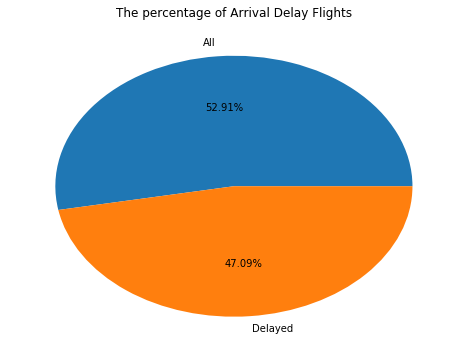

In [7]:
percent = df[df.ArrDelay >0]['ArrDelay'].count()

label=['All', 'Delayed']
val = [(df.shape[0]) ,percent]
plt.figure(figsize=(8,6))
plt.pie(val ,labels =label, autopct='%.2f%%');
plt.title('The percentage of Arrival Delay Flights')

## Is the Departure delay normally distributed ?

> The histogram show that the distribution of departure delay is right skewed.

([<matplotlib.axis.XTick at 0x7f745da11ba8>,
 <a list of 4 Text xticklabel objects>)

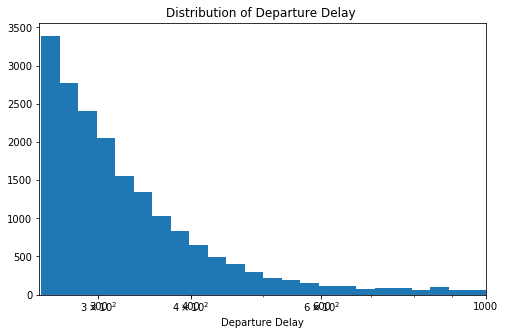

In [8]:
histPlot('DepDelay'  , 'Departure Delay', 'Distribution of Departure Delay ', log = True, xlim=  (250, 1000) )
plt.xticks([300, 400, 600, 1000],[300, 400, 600, 1000] )

## Which Airport have largest number of Flights?
> Southwest Airline Co (WN) have a huge number of flights which is double other Airlines

Text(0.5,0,'Airport code')

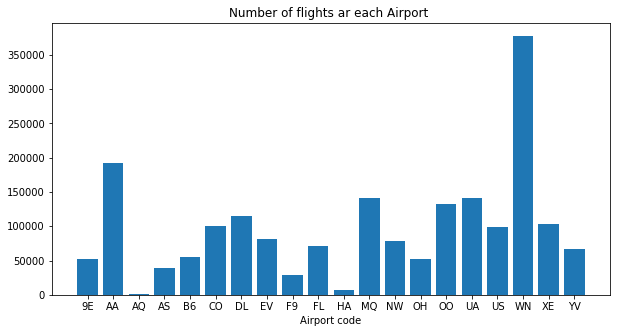

In [9]:
airlines = df.UniqueCarrier.value_counts()
plt.figure(figsize=[10, 5])
plt.bar(airlines.index, airlines) 

plt.title('Number of flights ar each Airport ')
plt.xlabel('Airport code')


## Is Departure delay lead to Arrival delay?
> From the graph it seems like when Departure delay occure; the Arrival delay occure also.
> I computed their correlation and it is 95% !! which prove our observation

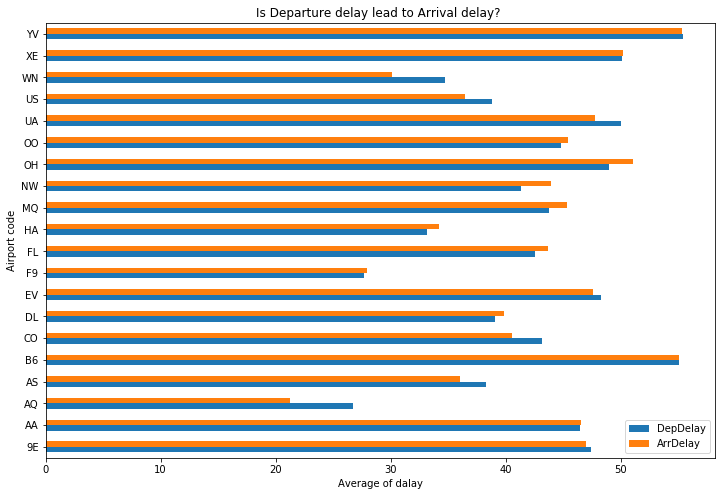

In [10]:
delayAir = df.loc[:, ['UniqueCarrier', 'DepDelay','ArrDelay']].groupby('UniqueCarrier').mean()
delayAir.plot.barh(figsize=(12,8), stacked=False)
plt.title('Is Departure delay lead to Arrival delay? ')
plt.xlabel('Average of dalay')
plt.ylabel('Airport code')
plt.show()

## What is the number of Delay in each Airline by Months and total flights?
> the visualization present only the last three months of the year, may be the delayed information of other months not provided in our data 

In [12]:
def flight_airline(airline):
    return df.loc[df['UniqueCarrier']==airline]


# split by month
flight_month = df.loc[:, ['Month']].groupby('Month').sum()
get_airline = df.UniqueCarrier.unique()

for a in get_airline:
    flight_month[a] = flight_airline(a).loc[:, ['Month', 'Cancelled']].groupby('Month').sum()


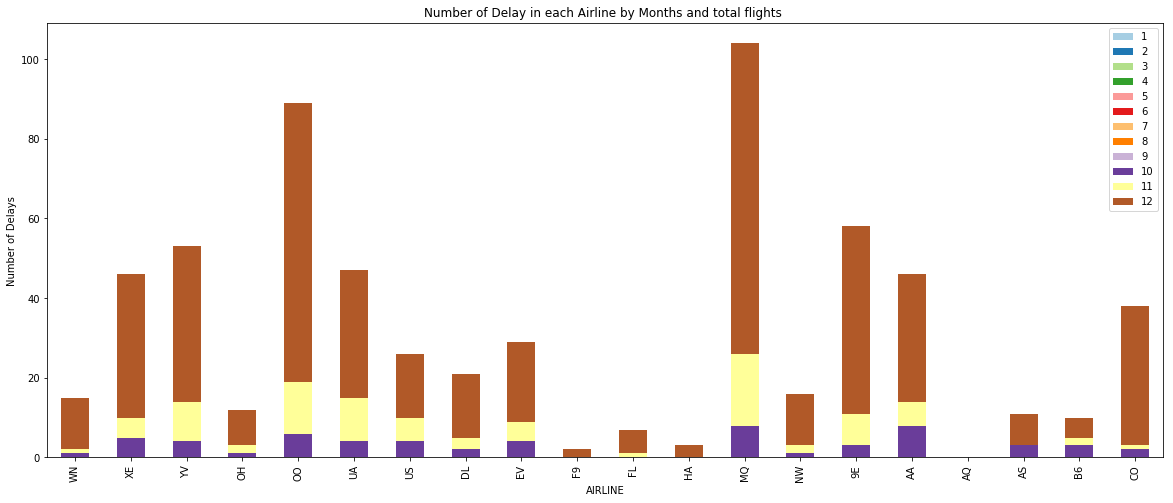

In [13]:
ax = flight_month.T.plot(kind='bar', stacked=True, figsize=(20,8), colormap= 'Paired')
ax.set(ylabel='Number of Delays', xlabel='AIRLINE')
ax.set_title('Number of Delay in each Airline by Months and total flights ')
ax.legend()
plt.show()

## what are the reaons of cancellation in each Airline?
> American Eagle Airlines Inc (MQ) have a large number of cancelation by wheather and NAS

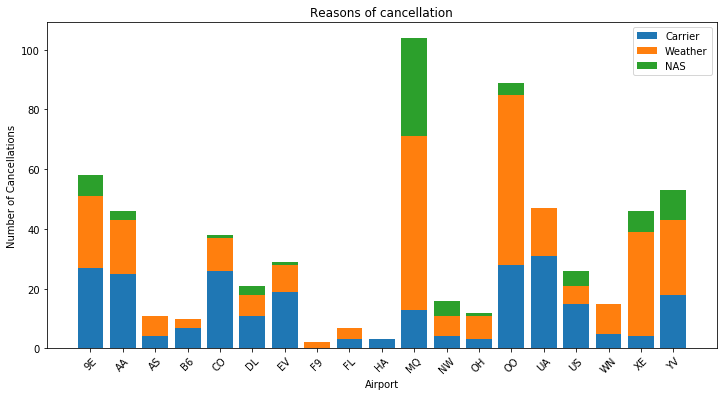

In [16]:
cancelled = df[df['Cancelled']==1]
cancelled = cancelled.reset_index()
cancelled.drop('index', axis=1, inplace=True)

cancelled_group = cancelled.groupby(['UniqueCarrier','CancellationCode']).size().reindex(fill_value=0.0).unstack()
cg = cancelled_group.fillna(0)

b_bottom = cg.loc[:,'Carrier'].values
c_bottom = b_bottom + cg.loc[:,'Weather'].values
d_bottom = c_bottom + cg.loc[:,'Weather'].values

x = cg.loc[:,'Carrier'].index.values

fig, ax = plt.subplots(figsize = (12,6))

ax.set_xticks(np.arange(len(x)))
ax.set_xticklabels(x, rotation = 45)
ax.bar(np.arange(len(x)),cg.loc[:,'Carrier'].values, align='center', label='Carrier')
ax.bar(np.arange(len(x)),cg.loc[:,'Weather'].values, align='center', bottom=b_bottom, label='Weather')
ax.bar(np.arange(len(x)),cg.loc[:,'NAS'].values, align='center', bottom=c_bottom, label='NAS')


ax.set_xlabel('Airport')
ax.set_ylabel('Number of Cancellations')

plt.legend()
plt.title('Reasons of cancellation')
plt.show()

## What is the Average Flights Diverted by months and weekdays?
> Friday in December have the largest rate of flights diverted, next Dec-Tuesday and Jun-Saturday

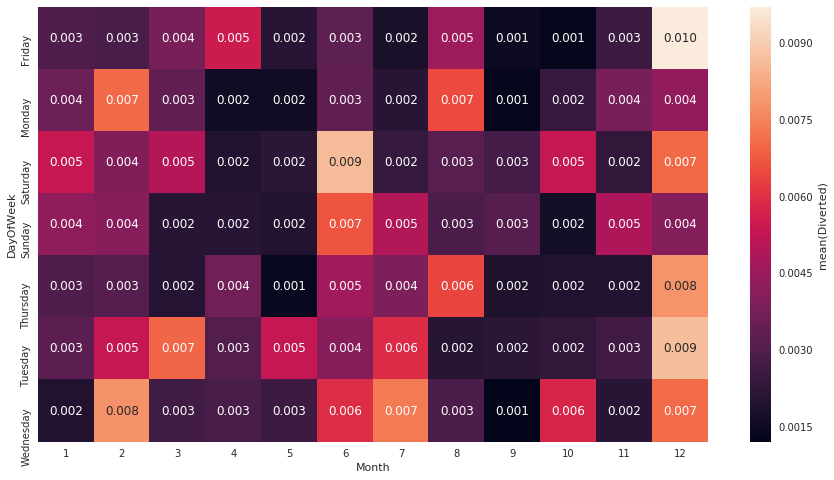

In [17]:
cat_means = df.groupby(['Month', 'DayOfWeek']).mean()['Diverted']
cat_means = cat_means.reset_index(name = 'Diverted_avg')
cat_means = cat_means.pivot(index = 'DayOfWeek', columns = 'Month',
                            values = 'Diverted_avg')
sb.set(rc = {'figure.figsize':(15,8)})
sb.heatmap(cat_means, annot = True, fmt = '.3f',
           cbar_kws = {'label' : 'mean(Diverted)'})


### Generate Slideshow
Once you're ready to generate your slideshow, use the `jupyter nbconvert` command to generate the HTML slide show.  

In [19]:
# Use this command if you are running this file in local
!jupyter nbconvert <Part_II_slide_deck>.ipynb --to slides --post serve --no-input --no-prompt

/bin/sh: 1: cannot open Part_II_slide_deck: No such file


> In the classroom workspace, the generated HTML slideshow will be placed in the home folder. 

> In local machines, the command above should open a tab in your web browser where you can scroll through your presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent slide. Make sure you remove all of the quote-formatted guide notes like this one before you finish your presentation! At last, you can stop the Kernel. 

### Submission
If you are using classroom workspace, you can choose from the following two ways of submission:

1. **Submit from the workspace**. Make sure you have removed the example project from the /home/workspace directory. You must submit the following files:
   - Part_I_notebook.ipynb
   - Part_I_notebook.html or pdf
   - Part_II_notebook.ipynb
   - Part_I_slides.html
   - README.md
   - dataset (optional)


2. **Submit a zip file on the last page of this project lesson**. In this case, open the Jupyter terminal and run the command below to generate a ZIP file. 
```bash
zip -r my_project.zip .
```
The command abobve will ZIP every file present in your /home/workspace directory. Next, you can download the zip to your local, and follow the instructions on the last page of this project lesson.
